# Wet vs. Dry Subset Comparison

## Setup

In [1]:
# Import statements
from typing import List, Union

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import scienceplots  # noqa: F401
import xarray as xr
from dask.base import compute
from dask.delayed import delayed
from dask.diagnostics.progress import ProgressBar
from matplotlib.colors import BoundaryNorm
from metpy.plots import ctables
from scipy.ndimage import gaussian_filter
from xskillscore import resample_iterations_idx

plt.style.use(["science", "nature"])
plt.rcParams["text.usetex"] = True
mpl.rcParams["hatch.linewidth"] = 0.2


In [2]:
def get_wofs_all(init: int) -> xr.Dataset:
    """Read in WoFS output based on initialization time."""
    file_pattern = f"/mnt/drive2/new-wofs/{init:02d}Z/wofs_ALL*.nc"
    loaded = xr.open_mfdataset(
        file_pattern, combine="nested", concat_dim="time", chunks="auto"
    )

    if init < 6:
        start_time = f"2021-09-02 {init:02d}:00:00"
        end_time = f"2021-09-02 {init + 6:02d}:00:00"
    else:
        start_time = f"2021-09-01 {init:02d}:00:00"
        end_time = f"2021-09-02 {init - 24 + 6:02d}:00:00"

    loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
    return loaded


def get_total_field(
    wofs_list: List[xr.Dataset],
    varname: str,
    start_time: str,
    end_time: str,
    init_dim: xr.DataArray,
) -> xr.DataArray:
    """
    Calculate the sum of a field (varname) for a given time slice across multiple datasets.

    Parameters:
    wofs_list (List[xr.Dataset]): List of xarray datasets.
    varname (str): Name of the variable from the Dataset to get.
    start_time (str): Start time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    end_time (str): End time for the time slice (format: 'YYYY-MM-DD HH:MM:SS').
    init_dim (str): Name of the dimension to concatenate along.

    Returns:
    xr.DataArray: Summed-up variable concatenated along the specified dimension.
    """
    return xr.concat(
        [
            w[varname].sel(time=slice(start_time, end_time)).sum(dim="time")
            for w in wofs_list
        ],
        dim=init_dim,
    ).chunk({"init": -1})


# Function to overwrite ne values
def overwrite_ne(da: xr.DataArray | xr.Dataset) -> xr.DataArray | xr.Dataset:
    da["ne"] = range(5)
    return da


def process_dim(da: xr.DataArray) -> xr.DataArray:
    """Helper function to process DataArray with or without time dimension"""
    ens_mean = da.mean(dim="run").stack(i=("lat", "lon"))
    sorted_mean = ens_mean.sortby(ens_mean)
    sorted_all = np.sort(da.values.flatten())[:: len(da.run)]
    sorted_mean.values = sorted_all
    return sorted_mean.unstack("i")


def pmm(da: xr.DataArray) -> xr.DataArray:
    """Compute the probability matched mean of a DataArray"""
    if "time" in da.dims:
        results = []
        for time_slice in da.time:
            time_da = da.sel(time=time_slice)
            results.append(process_dim(time_da))
        return xr.concat(results, dim="time")
    else:
        return process_dim(da)


@delayed
def bootstrap_iteration(da: xr.DataArray, sample_size: int) -> xr.DataArray:
    """Single iteration of bootstrapping"""
    # Sample without replacement
    sample1 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))
    sample2 = da.sel(run=np.random.choice(da.run, sample_size, replace=False))

    # Compute PMM for each sample
    pmm1 = pmm(sample1)
    pmm2 = pmm(sample2)

    # Compute difference of PMMs
    diff = pmm1 - pmm2
    return diff


def bootstrap_pmm_difference(
    da: xr.DataArray, sample_size: int, iterations: int
) -> xr.DataArray:
    """Perform bootstrapping and compute differences of PMM"""
    tasks = [bootstrap_iteration(da, sample_size) for _ in range(iterations)]
    results = compute(*tasks)
    return xr.concat(results, dim="iteration")


def get_smoothed_ds(
    da: xr.DataArray, sigma: Union[float, int], axes: Union[str, List[str]] = None
):
    """
    Apply a Gaussian filter to specific dimensions of an xarray.DataArray and return
    a Dataset containing both the original and smoothed data.

    Parameters:
    - da (xr.DataArray): Input data array.
    - sigma (float or int): Standard deviation for the Gaussian kernel.
    - axes (str or List[str], optional): Dimensions to smooth over. Defaults to all dimensions.

    Returns:
    - xr.Dataset: A dataset containing the original and smoothed DataArrays.
    """
    # Type checking
    if not isinstance(da, xr.DataArray):
        raise TypeError("Input must be an xarray.DataArray.")
    if not isinstance(sigma, (float, int)):
        raise TypeError("Sigma must be a float or an integer.")
    if axes is not None and not isinstance(axes, (str, list)):
        raise TypeError("Axes must be a string, a list of strings, or None.")

    # Convert a single axis string to a list
    if isinstance(axes, str):
        axes = [axes]

    # If no axes specified, apply to all dimensions
    if axes is None:
        axes = list(da.dims)

    # Convert dimension names to axis indices
    try:
        axis_indices = [da.get_axis_num(dim) for dim in axes]
    except ValueError as e:
        raise ValueError(f"Invalid axis name in {axes}: {e}")

    # Construct full sigma array where only selected axes are smoothed
    full_sigma = [sigma if i in axis_indices else 0 for i in range(da.ndim)]

    # Apply the Gaussian filter
    smoothed_data = gaussian_filter(da.values, sigma=full_sigma)

    # Create a new DataArray with the same metadata
    smoothed_da = xr.DataArray(
        smoothed_data,
        dims=da.dims,
        coords=da.coords,
        attrs={
            **da.attrs,
            "description": f"Gaussian smoothed (sigma={sigma}) over {axes}",
        },
    )

    # Combine original and smoothed data into a Dataset
    ds = xr.Dataset({"original": da, "smoothed": smoothed_da})

    return ds


In [3]:
# Read in 2000- 2300 UTC initializations
wofs_all = [get_wofs_all(i) for i in [20, 21, 22, 23]]

# Make a new DataArray
init = xr.DataArray(data=["20Z", "21Z", "22Z", "23Z"], dims="init")
init = init.assign_coords({"init": init})

lat = wofs_all[0].xlat.isel(time=0).squeeze().drop_vars("time")
lon = wofs_all[0].xlon.isel(time=0).squeeze().drop_vars("time")

# Set up Cartopy projection
proj = ccrs.LambertConformal(
    central_longitude=wofs_all[0].attrs["CEN_LON"],
    central_latitude=wofs_all[0].attrs["CEN_LAT"],
    standard_parallels=(30, 60),
)  # this is the projection that WoFS uses

# Get MetPy precipitation colortable
precip_cmap = ctables.registry.get_colortable("precipitation")
refl_cmap = ctables.registry.get_colortable("NWSReflectivity")


/tmp/ipykernel_3876261/987834175.py:15: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3876261/987834175.py:15: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3876261/987834175.py:15: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")
/tmp/ipykernel_3876261/987834175.py:15: DeprecationWarning: cftime_range() is deprecated, please use xarray.date_range(..., use_cftime=True) instead.
  loaded["time"] = xr.cftime_range(start_time, end_time, freq="5min")


## Create Subsets

In [4]:
# Get the 01 to 02 UTC rainfall
rain12 = get_total_field(
    wofs_all, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
)

# Calculate standard deviation of rainfall
std = rain12.std(dim=("init", "ne"))

# Lastly, make our area of interest where sd > 65% of max sd
aoi = std > (std.max() * 0.65)

rain12_aoi = rain12.where(aoi).mean(dim=("lat", "lon"), skipna=True)

# Grab the 5 wettest and driest ensemble members
ranking = [r.ne.sortby(r).load() for r in rain12_aoi]
driest, wettest = [r[:5] for r in ranking], [r[-5:] for r in ranking]


In [5]:
# Get the indices of the wettest and driest ensemble members
ne_wet = [
    r.ne.where(r > r.quantile(0.75, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]
ne_dry = [
    r.ne.where(r < r.quantile(0.25, dim="ne")).dropna(dim="ne").drop_vars("quantile")
    for r in rain12_aoi
]

wofs_wet = [wofs_all[i].sel(ne=ne_wet[i].astype(int)) for i in range(len(wofs_all))]
wofs_dry = [wofs_all[i].sel(ne=ne_dry[i].astype(int)) for i in range(len(wofs_all))]


### Precipitation

In [6]:
# Prepare 01-02 UTC rainfall
rain12_all = rain12.stack(run=("init", "ne")).chunk({"run": -1})
rain12_wet = (
    get_total_field(
        wofs_wet, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)
rain12_dry = (
    get_total_field(
        wofs_dry, "rain", "2021-09-02 01:05:00", "2021-09-02 02:00:00", init_dim=init
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)


In [7]:
# Get difference in probability matched mean
diff = pmm(rain12_wet) - pmm(rain12_dry)

# Find bootstrapped statistical significance
quantiles = (
    bootstrap_pmm_difference(rain12_all, sample_size=20, iterations=1000)
    .quantile([0.025, 0.975], dim="iteration")
    .compute()
)

# Mask where values > 95th percentile or < 5th percentile
mask = (diff < quantiles.sel(quantile=0.025).squeeze()) | (  # type: ignore
    diff > quantiles.sel(quantile=0.975).squeeze()  # type: ignore
)


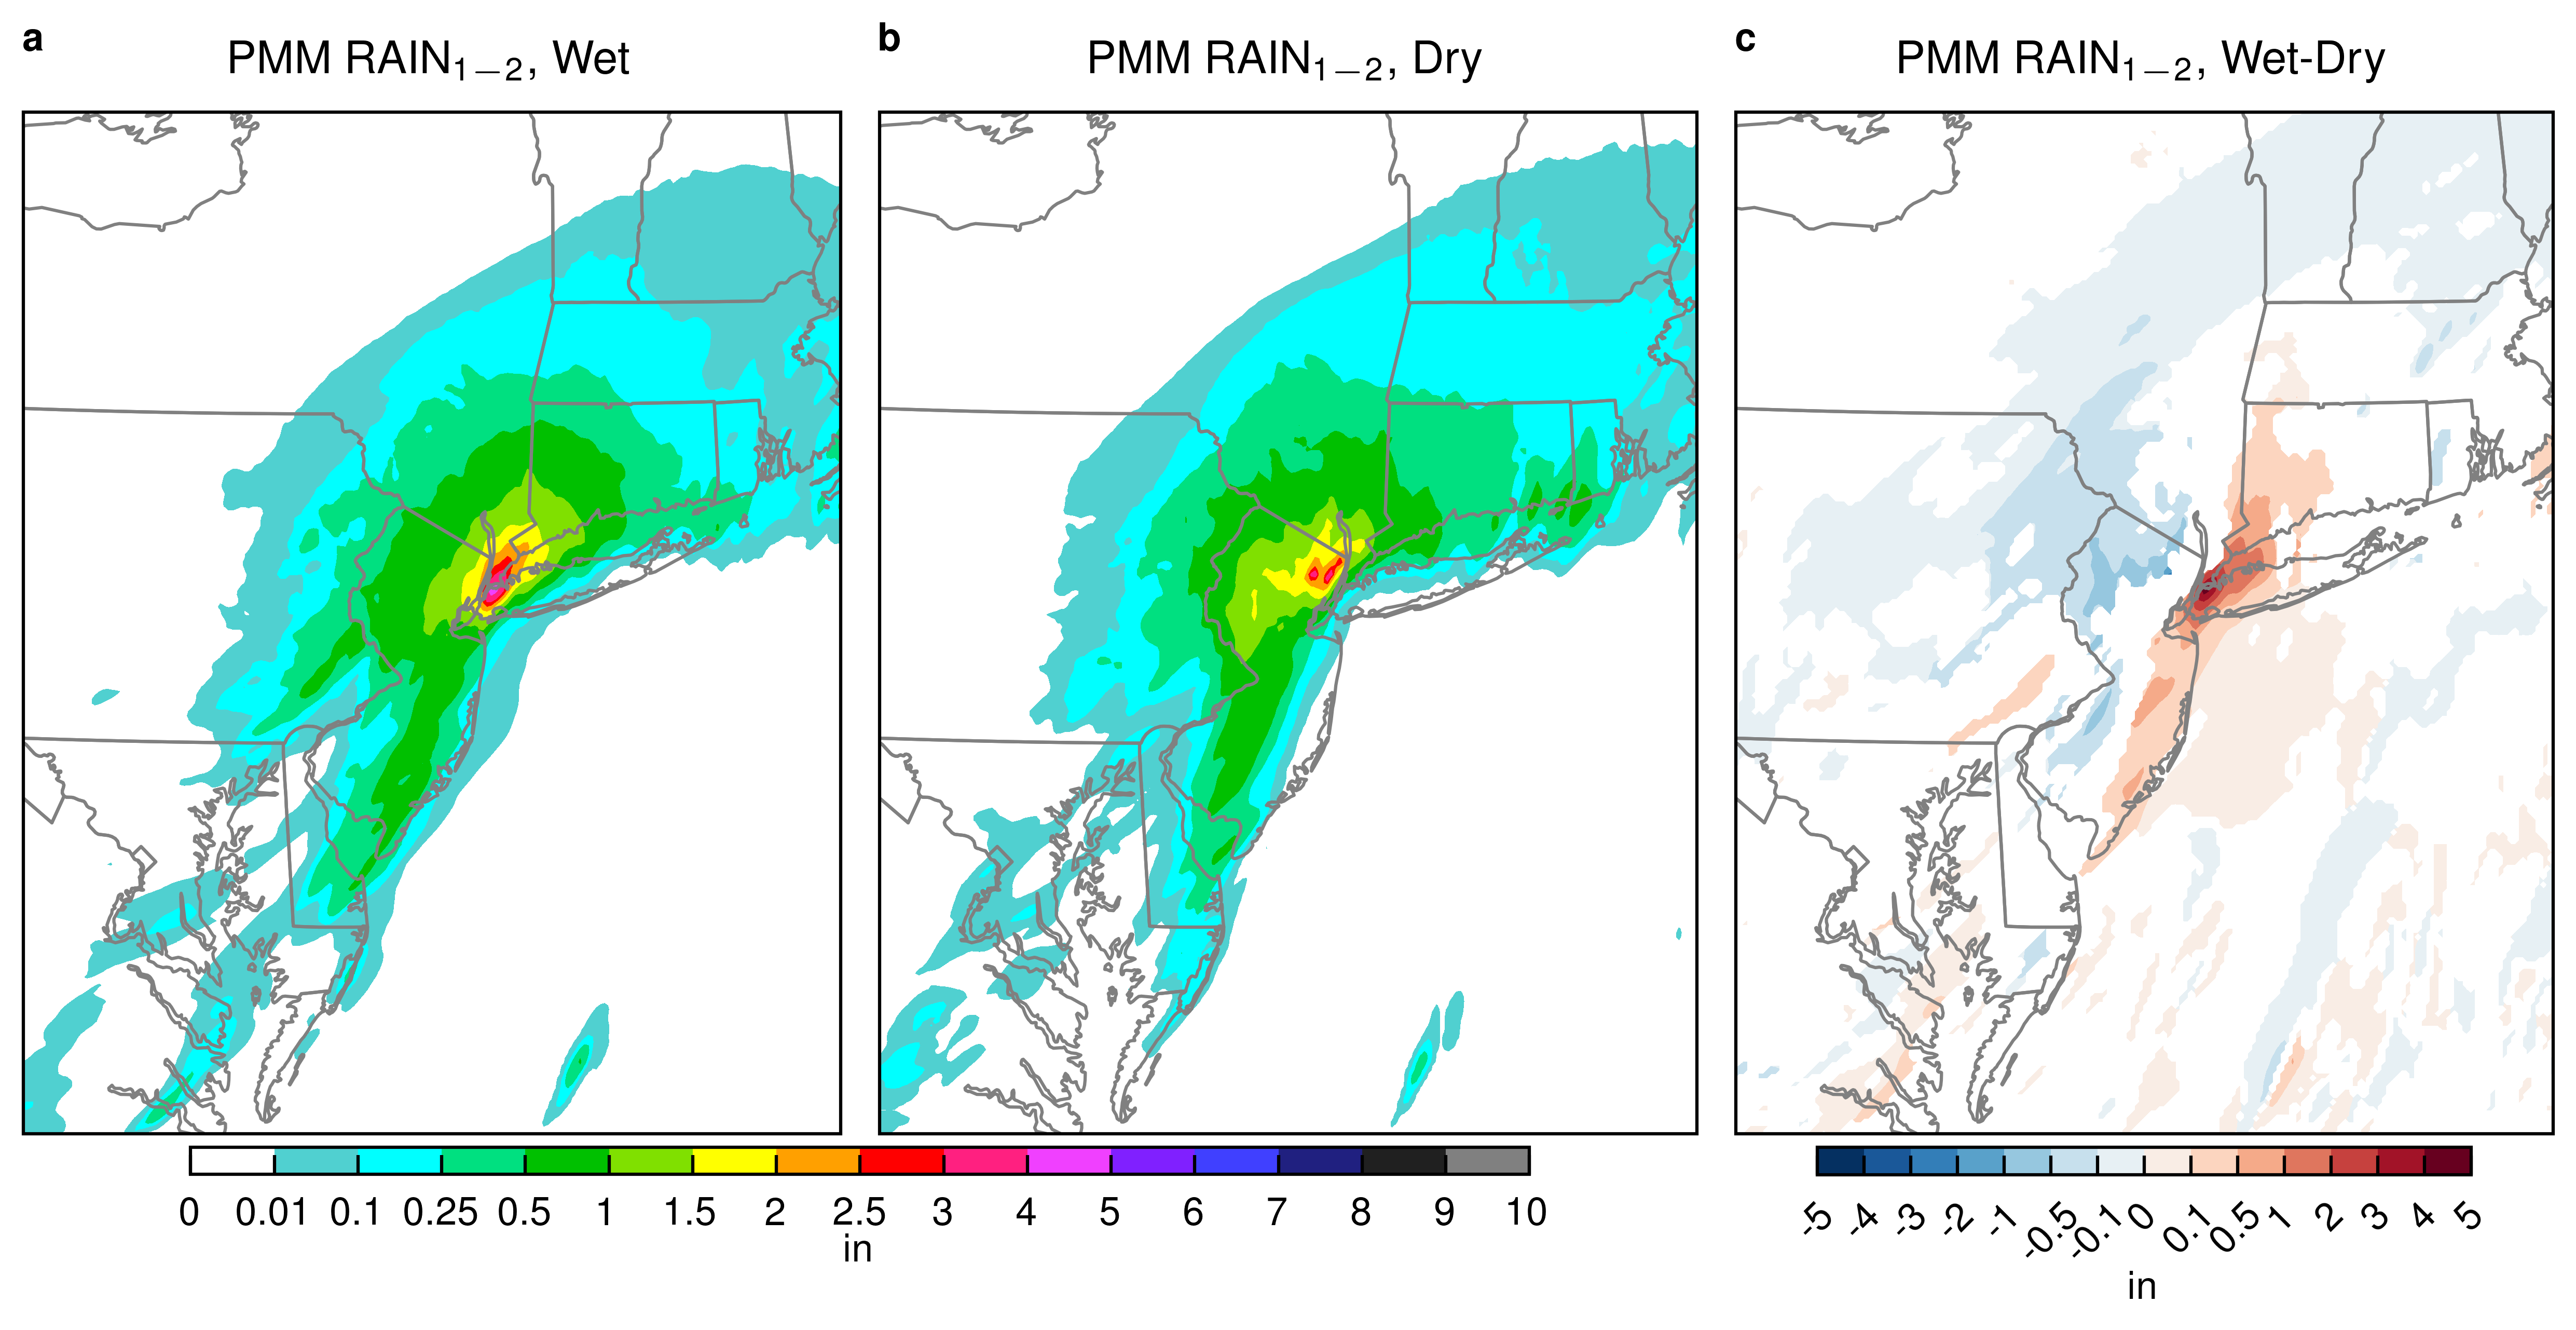

In [8]:
rain_values = [r.load() for r in [pmm(rain12_wet), pmm(rain12_dry), diff]]
titles = ["PMM RAIN$_{1-2}$, Wet", "PMM RAIN$_{1-2}$, Dry", "PMM RAIN$_{1-2}$, Wet-Dry"]
levels = [0, 0.01, 0.1, 0.25, 0.50, 1, 1.5, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10]
# diff_levels = [-4, -2, -1, -0.5, -0.1, 0,0.1, 0.5, 1, 2, 4]
diff_levels = [-5, -4, -3, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 3, 4, 5]

# Create a normalization object
pnorm = mcolors.BoundaryNorm(levels, ncolors=len(levels) - 1, clip=False)

fig, axes = plt.subplots(
    1,
    3,
    figsize=(5.5, 3),
    dpi=900,
    subplot_kw=dict(projection=proj),
    layout="constrained",
)

# Define colormap and normalization for the third panel
cmap = plt.get_cmap("RdBu_r")
dnorm = BoundaryNorm(diff_levels, ncolors=cmap.N, clip=True)

for i, ax in enumerate(axes.flatten()):
    if i != 2:
        c1 = ax.contourf(
            lon,
            lat,
            rain_values[i],
            cmap=precip_cmap,
            levels=levels,
            transform=ccrs.PlateCarree(),
            norm=pnorm,
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="gray")

    else:
        c2 = ax.contourf(
            lon,
            lat,
            rain_values[i].where(mask),
            transform=ccrs.PlateCarree(),
            levels=diff_levels,
            cmap=cmap,
            norm=dnorm,
        )
        ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="gray")

    ax.set_title(titles[i], fontsize=7)
    ax.set_extent([-78, -71, 37, 44])

cb1 = fig.colorbar(
    c1, ax=axes[0:2], orientation="horizontal", shrink=0.8, pad=0.01, aspect=50
)
cb1.ax.tick_params(labelsize=6)
cb1.set_ticks(levels)
cb1.set_ticklabels(levels)
cb1.set_label("in", fontsize=6, labelpad=0.1)

cb2 = fig.colorbar(
    c2, ax=axes[2], orientation="horizontal", shrink=0.8, pad=0.01, aspect=24
)
cb2.ax.tick_params(labelsize=6)
cb2.set_ticks(diff_levels)
cb2.set_ticklabels(diff_levels, rotation=45)
cb2.set_label("in", fontsize=6, labelpad=0.1)

letters = ["a", "b", "c"]
for i, ax in enumerate(axes.flatten()):
    ax.text(
        -0, 1.06, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=6
    )

# Save fig
plt.savefig("figures/Fig7_PMM_rainfall.pdf", bbox_inches="tight")


### PW & MLCAPE

In [9]:
# Gather 2300, 0000, and 0100 UTC PW
pw_all = (
    xr.concat(
        [
            get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed
            for w in wofs_all
        ],
        dim=init,
    )
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)
pw_wet = (
    xr.concat(
        [
            overwrite_ne(get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed)
            for w in wofs_wet
        ],  # type: ignore
        dim=init,
    )  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
pw_dry = (
    xr.concat(
        [
            overwrite_ne(get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed)
            for w in wofs_dry
        ],  # type: ignore
        dim=init,
    )  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)


In [10]:
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
results = []

for time in times:
    pw_chunked = pw_all.sel(time=time).squeeze().chunk({"lat": 25, "lon": 25})

    # Resample and compute means
    set1 = resample_iterations_idx(
        pw_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=20,
    ).mean(dim="run")

    set2 = resample_iterations_idx(
        pw_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=20,
    ).mean(dim="run")

    # Compute the difference and quantiles
    with ProgressBar():
        result = (set1 - set2).quantile([0.025, 0.975], dim="iteration").compute()
        results.append(result)

# Combine results along the new time dimension
results = xr.concat(results, dim="time")


[                                        ] | 0% Completed | 356.88 us

[########################################] | 100% Completed | 10.31 ss
[########################################] | 100% Completed | 10.33 ss
[########################################] | 100% Completed | 10.43 ss


In [11]:
with ProgressBar():
    pw_wet = (
        xr.concat([pw_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    pw_dry = (
        xr.concat([pw_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
pw_diff = pw_wet - pw_dry
pw_mask = (pw_diff < results.sel(quantile=0.025).squeeze()) | (  # type: ignore
    pw_diff > results.sel(quantile=0.975).squeeze()  # type: ignore
)


[########################################] | 100% Completed | 309.51 ms
[########################################] | 100% Completed | 309.37 ms


In [12]:
# Repeat process for MLCAPE
pw_all = (
    xr.concat(
        [
            get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed
            for w in wofs_all
        ],
        dim=init,
    )
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)
pw_wet = (
    xr.concat(
        [
            overwrite_ne(get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed)
            for w in wofs_wet
        ],  # type: ignore
        dim=init,
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)
pw_dry = (
    xr.concat(
        [
            overwrite_ne(get_smoothed_ds(w.pw, sigma=3, axes=["lat", "lon"]).smoothed)
            for w in wofs_dry
        ],  # type: ignore
        dim=init,
    )
    .chunk("auto")
    .stack(run=("init", "ne"))
)


In [13]:
# Gather 2300, 0000, and 0100 UTC mlcape
mlcape_all = (
    xr.concat(
        [
            get_smoothed_ds(w.cape_ml, sigma=3, axes=["lat", "lon"]).smoothed
            for w in wofs_all
        ],
        dim=init,
    )
    .stack(run=("init", "ne"))
    .chunk({"run": -1})
)
mlcape_wet = (
    xr.concat(
        [
            overwrite_ne(
                get_smoothed_ds(w.cape_ml, sigma=3, axes=["lat", "lon"]).smoothed
            )
            for w in wofs_wet
        ],  # type: ignore
        dim=init,
    )  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)
mlcape_dry = (
    xr.concat(
        [
            overwrite_ne(
                get_smoothed_ds(w.cape_ml, sigma=3, axes=["lat", "lon"]).smoothed
            )
            for w in wofs_dry
        ],  # type: ignore
        dim=init,
    )  # type: ignore
    .chunk("auto")
    .stack(run=("init", "ne"))
)


times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
results = []

for time in times:
    mlcape_chunked = mlcape_all.sel(time=time).squeeze().chunk({"lat": 25, "lon": 25})

    # Resample and compute means
    set1 = resample_iterations_idx(
        mlcape_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=20,
    ).mean(dim="run")

    set2 = resample_iterations_idx(
        mlcape_chunked,
        1000,
        dim="run",
        replace=False,
        dim_max=20,
    ).mean(dim="run")

    # Compute the difference and quantiles
    with ProgressBar():
        result = (set1 - set2).quantile([0.025, 0.975], dim="iteration").compute()
        results.append(result)

# Combine results along the new time dimension
results = xr.concat(results, dim="time")

with ProgressBar():
    mlcape_wet = (
        xr.concat([mlcape_wet.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
    mlcape_dry = (
        xr.concat([mlcape_dry.sel(time=t).squeeze() for t in times], dim="time")
        .mean(dim="run")
        .compute()
    )
mlcape_diff = mlcape_wet - mlcape_dry
mlcape_mask = (mlcape_diff < results.sel(quantile=0.025).squeeze()) | (  # type: ignore
    mlcape_diff > results.sel(quantile=0.975).squeeze()  # type: ignore
)


[########################################] | 100% Completed | 10.44 ss
[########################################] | 100% Completed | 10.32 ss
[########################################] | 100% Completed | 10.48 ss
[########################################] | 100% Completed | 413.67 ms
[########################################] | 100% Completed | 310.26 ms


In [14]:
mlcape_all_unsmoothed = xr.concat(
    [w.cape_ml for w in wofs_all],
    dim=init,
).stack(run=("init", "ne"))


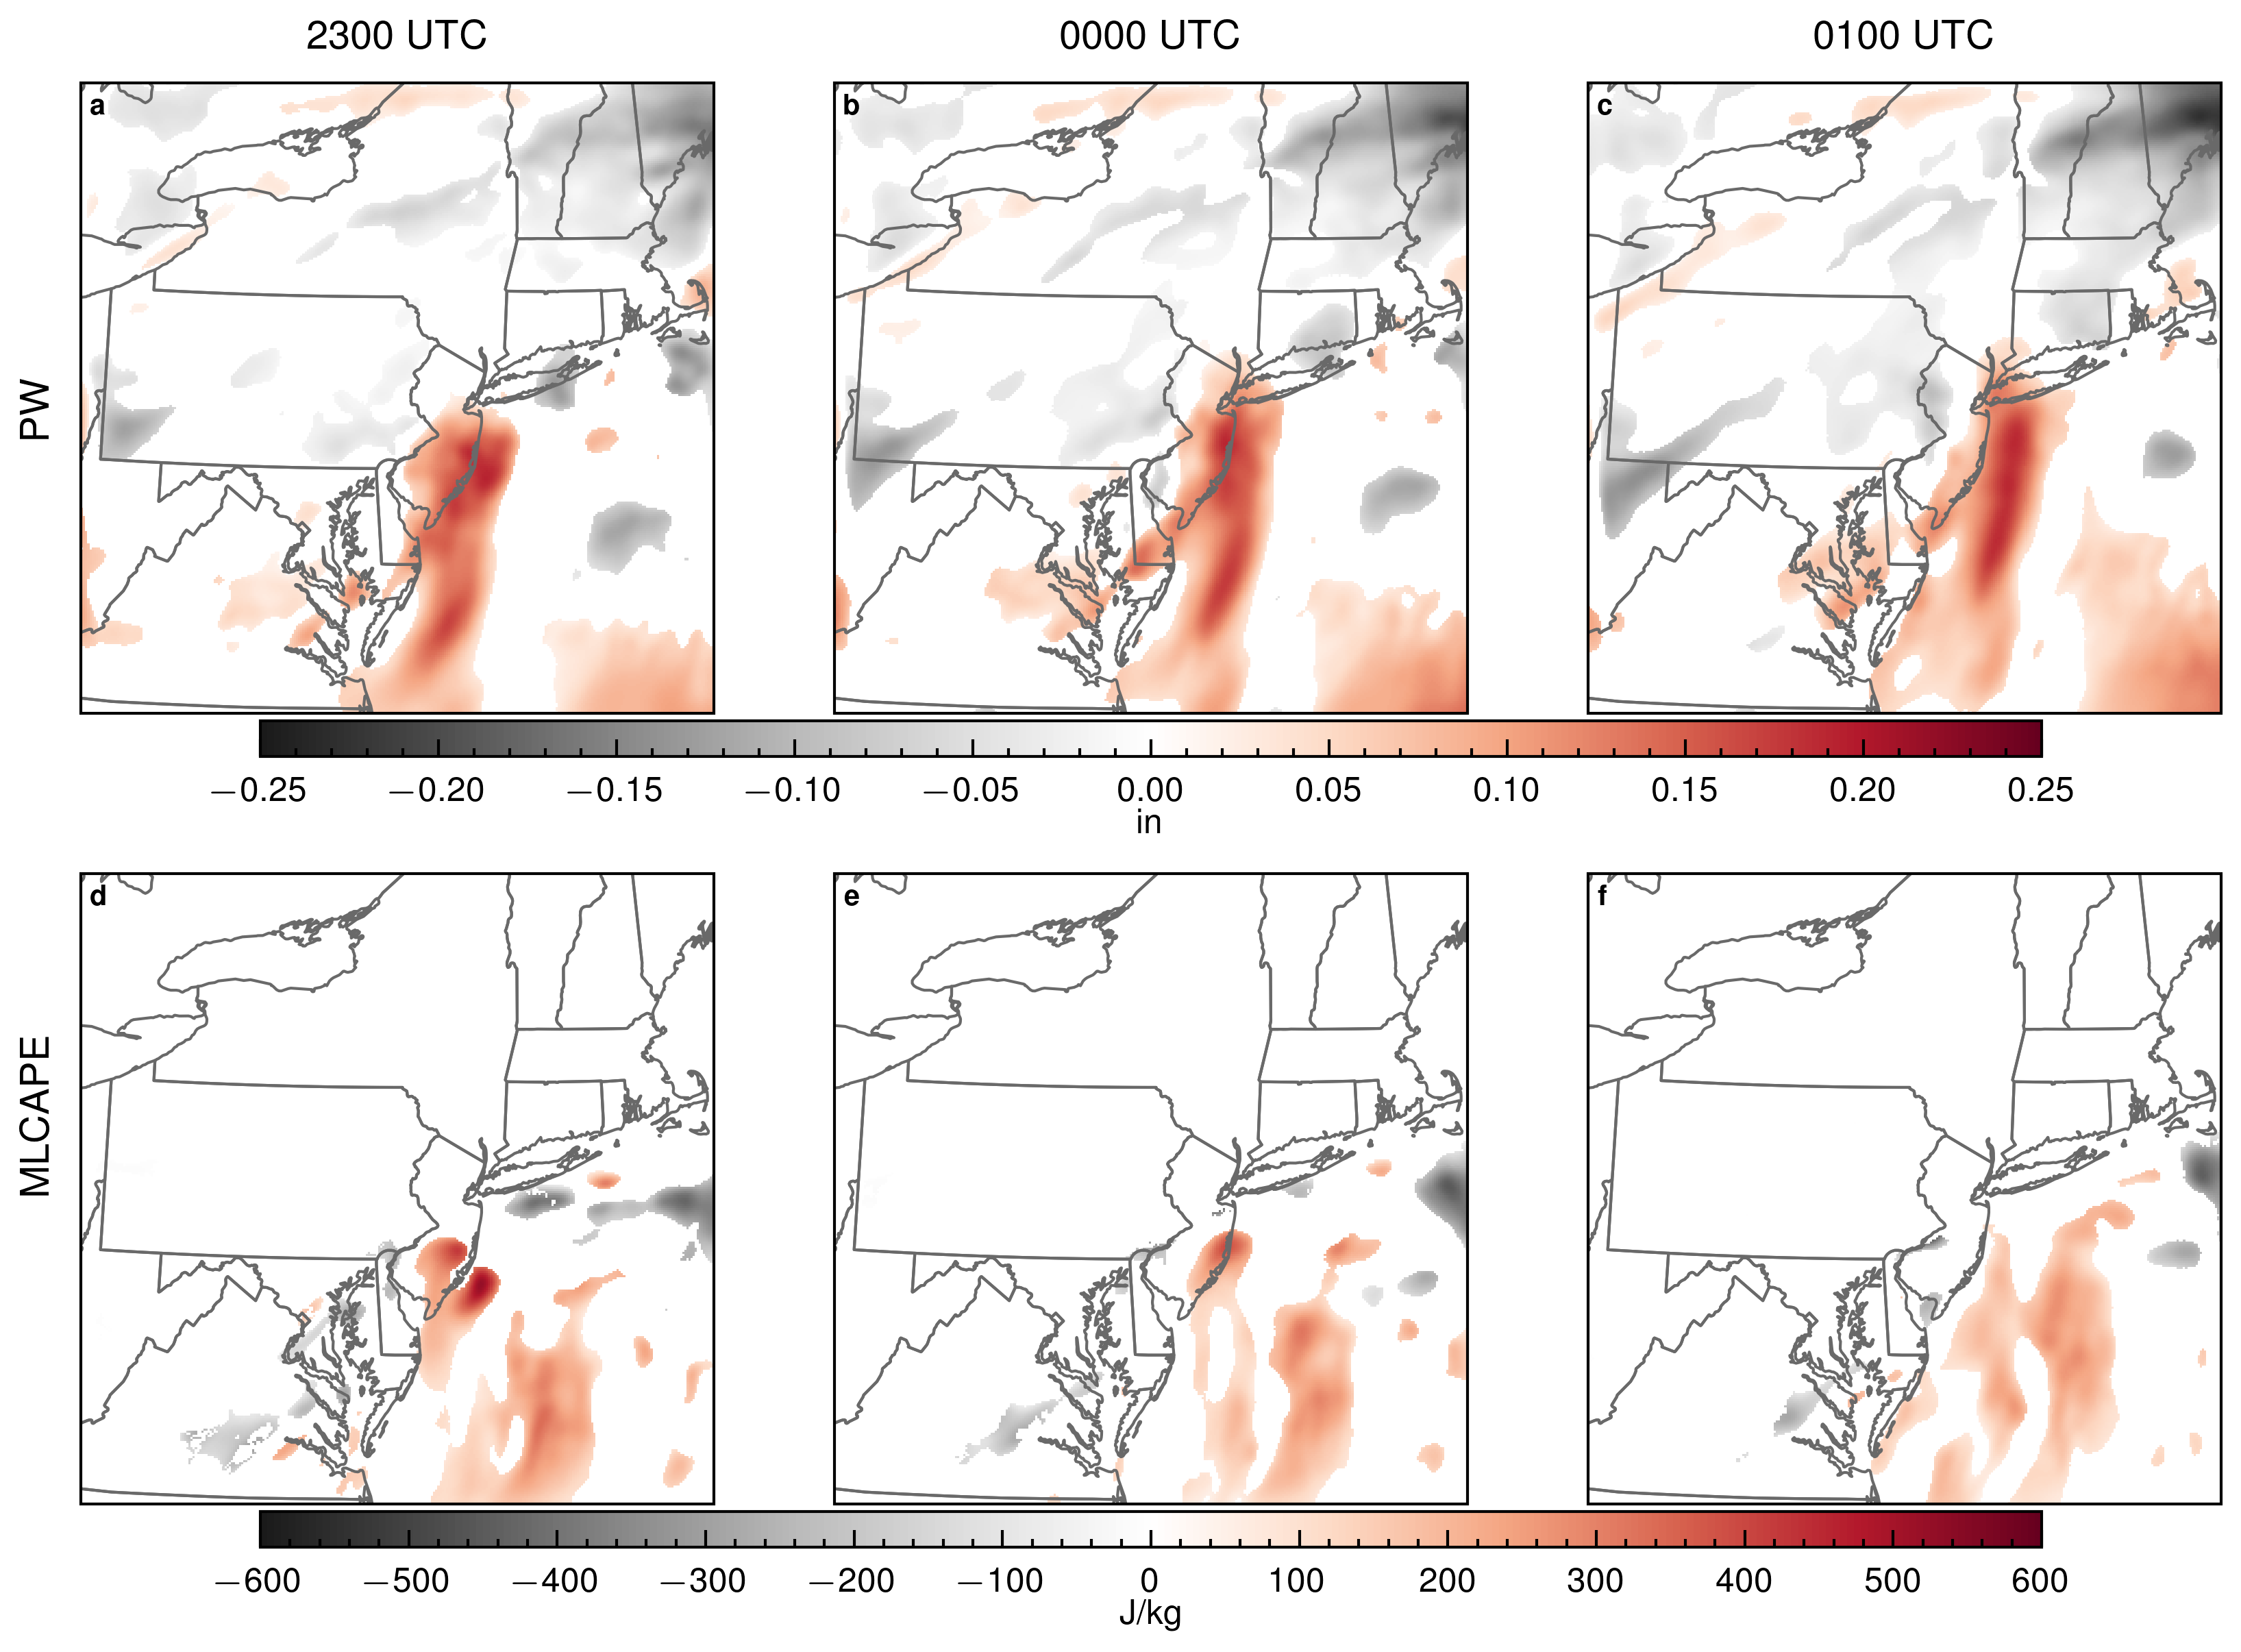

In [16]:
letters = ["a", "b", "c", "d", "e", "f"]
column_titles = ["2300 UTC", "0000 UTC", "0100 UTC"]
times = ["2021-09-01 23:00:00", "2021-09-02 00:00:00", "2021-09-02 01:00:00"]
units_labels = ["in", "J/kg"]
ticks = [np.arange(-0.25, 0.26, 0.05), np.arange(-600, 601, 100)]


diffs = [pw_diff.sel(time=t).squeeze() for t in times] + [
    mlcape_diff.sel(time=t).squeeze() for t in times
]
masks = [pw_mask.sel(time=t).squeeze() for t in times] + [
    mlcape_mask.sel(time=t).squeeze() for t in times
]
mlcapes = [mlcape_all_unsmoothed.sel(time=t).squeeze() for t in times]

cmap = plt.get_cmap("RdGy_r")
# Create figure and subplots
fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(5.5, 4),
    dpi=600,
    layout="constrained",
    subplot_kw=dict(projection=proj),
)

for i, ax in enumerate(axes.flat):
    if i <= 2:
        ax.set_title(column_titles[i], fontsize=7)
        cond = masks[i]
        vmin = -0.25
        vmax = 0.25
    else:
        cond = masks[i] & (mlcapes[i - 3].min(dim="run") > 0)
        levels = np.arange(-600, 601, 100)
        vmin = -600
        vmax = 600

    # Plot the standardized sensitivities
    pc = ax.pcolormesh(
        lon,
        lat,
        diffs[i].where(cond),
        cmap=cmap,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        rasterized=True,
    )

    ax.add_feature(cfeature.STATES, linewidth=0.5, edgecolor="dimgray", zorder=2)
    ax.text(
        0.015, 0.95, r"\textbf{" + letters[i] + "}", transform=ax.transAxes, fontsize=5
    )

    # Add one colorbar per row
    if i == 2 or i == 5:
        cb = fig.colorbar(
            pc,
            ax=axes[i // 3, :],
            orientation="horizontal",
            shrink=0.8,
            pad=0.01,
            aspect=50,
        )
        cb.ax.tick_params(labelsize=6)
        cb.set_ticks(ticks[i // 3])
        cb.set_label(units_labels[i // 3], fontsize=6, labelpad=0.1)

fig.text(0.0, 0.74, "PW", rotation=90, fontsize=7)
fig.text(0.0, 0.28, "MLCAPE", rotation=90, fontsize=7)

# Save figs
plt.savefig("figures/FigS4-pw-mlcape-diffs.pdf", bbox_inches="tight")
# plt.show()
